<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [227]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import math
import re

# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk
import contractions
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Para sistemas de recomendacion basados en cotenido
# -----------------------------------------------------------------------
from scipy.spatial.distance import pdist , squareform   # Para calcular la distancia entre puntos 
from sklearn.feature_extraction.text import CountVectorizer # Vectorizacion / tokenizacion 
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)

# Otros
# -----------------------------------------------------------------------
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from src import soporte_nlp as snlp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importación de los datos

In [211]:
df = pd.read_csv("datos/datos.csv", index_col=0)
df.head(2)

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
65115,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
56720,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0


- Dado que sólo tenemos 99 productos, debemos agrupar los productos y sumar las reviews.

In [212]:
df["productName"].nunique()

99

- Filtramos las columnas que nos interesan

In [213]:
df = df[['productName', 'reviewText', 'mainDepartment', 'subDepartment']]

In [214]:
df.head(1)

,productName,reviewText,mainDepartment,subDepartment
65115,Doctor Developed Copper Wrist Brace / Carpal T...,Nice lightweight brace but unfortunately was t...,Sports and Outdoors,Outdoor Recreation


In [215]:
df.dropna(subset="reviewText", inplace=True)

In [216]:
df = df.groupby(['productName', 'mainDepartment', 'subDepartment']).agg({
    'reviewText': ' '.join
}).reset_index()

df.head(5)

,productName,mainDepartment,subDepartment,reviewText
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",Electronics,CellPhones and Accessories,I’ll admit I was very skeptical from reviews b...
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,Beauty and Personal Care,"Foot,Hand & Nail Care","It’s thick, but works good once you get used t..."
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,Electronics,Camera and Accessories,I was not impressed with the image quality. A...
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",Computers,Computers & Tablets,The laptop arrived just in time for school!! W...
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Computers,Computers & Tablets,Bought for school work. Doing good so far.Slee...


In [217]:
df["reviewText"][0]

'I’ll admit I was very skeptical from reviews but I decided to purchase anyways…. and so far so good! Battery life is about 7 hours of constant use (games, videos, etc). Sounds is good. I had no problems connecting to internet. The border of the phone did appear to have some scratches but not too many. The phone I received has a loose charging port that should have been replaced. It was at 27% just now and I plugged it in and opened an app. Now it just gave me the under 20% notification so it’s obviously struggling to keep the cord in place. No working well can\'t download any apps horrible phone My old Android works better than this junk. Please refund money. Diana Manuele It’s for personal and the battery life issues is crazy it’s only take 2 hours Worked slow, barely charged. Battery life is not good at all. Only last an hour. The worse I never bought. Battery is dead and I sent it in Africa, so no way to return it. Just lost my money. I could give 0 star I’m very picky with my phon

In [218]:
df.isna().sum()

productName       0
mainDepartment    0
subDepartment     0
reviewText        0
dtype: int64

In [219]:
#df["reviewerName"].value_counts()[df["reviewerName"].value_counts() ==1].shape

## Paso #1: preprocesamiento del texto

- Instanciamos la clase y limpiamos el texto.

In [220]:
exp_nlp = snlp.ExploracionText(df, "reviewText", "productName")

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   productName     99 non-null     object
 1   mainDepartment  99 non-null     object
 2   subDepartment   99 non-null     object
 3   reviewText      99 non-null     object
dtypes: object(4)
memory usage: 3.2+ KB
None

Descripción del DataFrame:
               count unique  \
productName       99     99   
mainDepartment    99      5   
subDepartment     99     27   
reviewText        99     99   

                                                              top freq  
productName     (Refurbished) Apple iPhone 7, 32GB, Black - Fu...    1  
mainDepartment                                          Computers   36  
subDepartment                                 Computers & Tablets    8  
reviewText      I’ll admit I was very skeptical from reviews b...    1  

Distribución

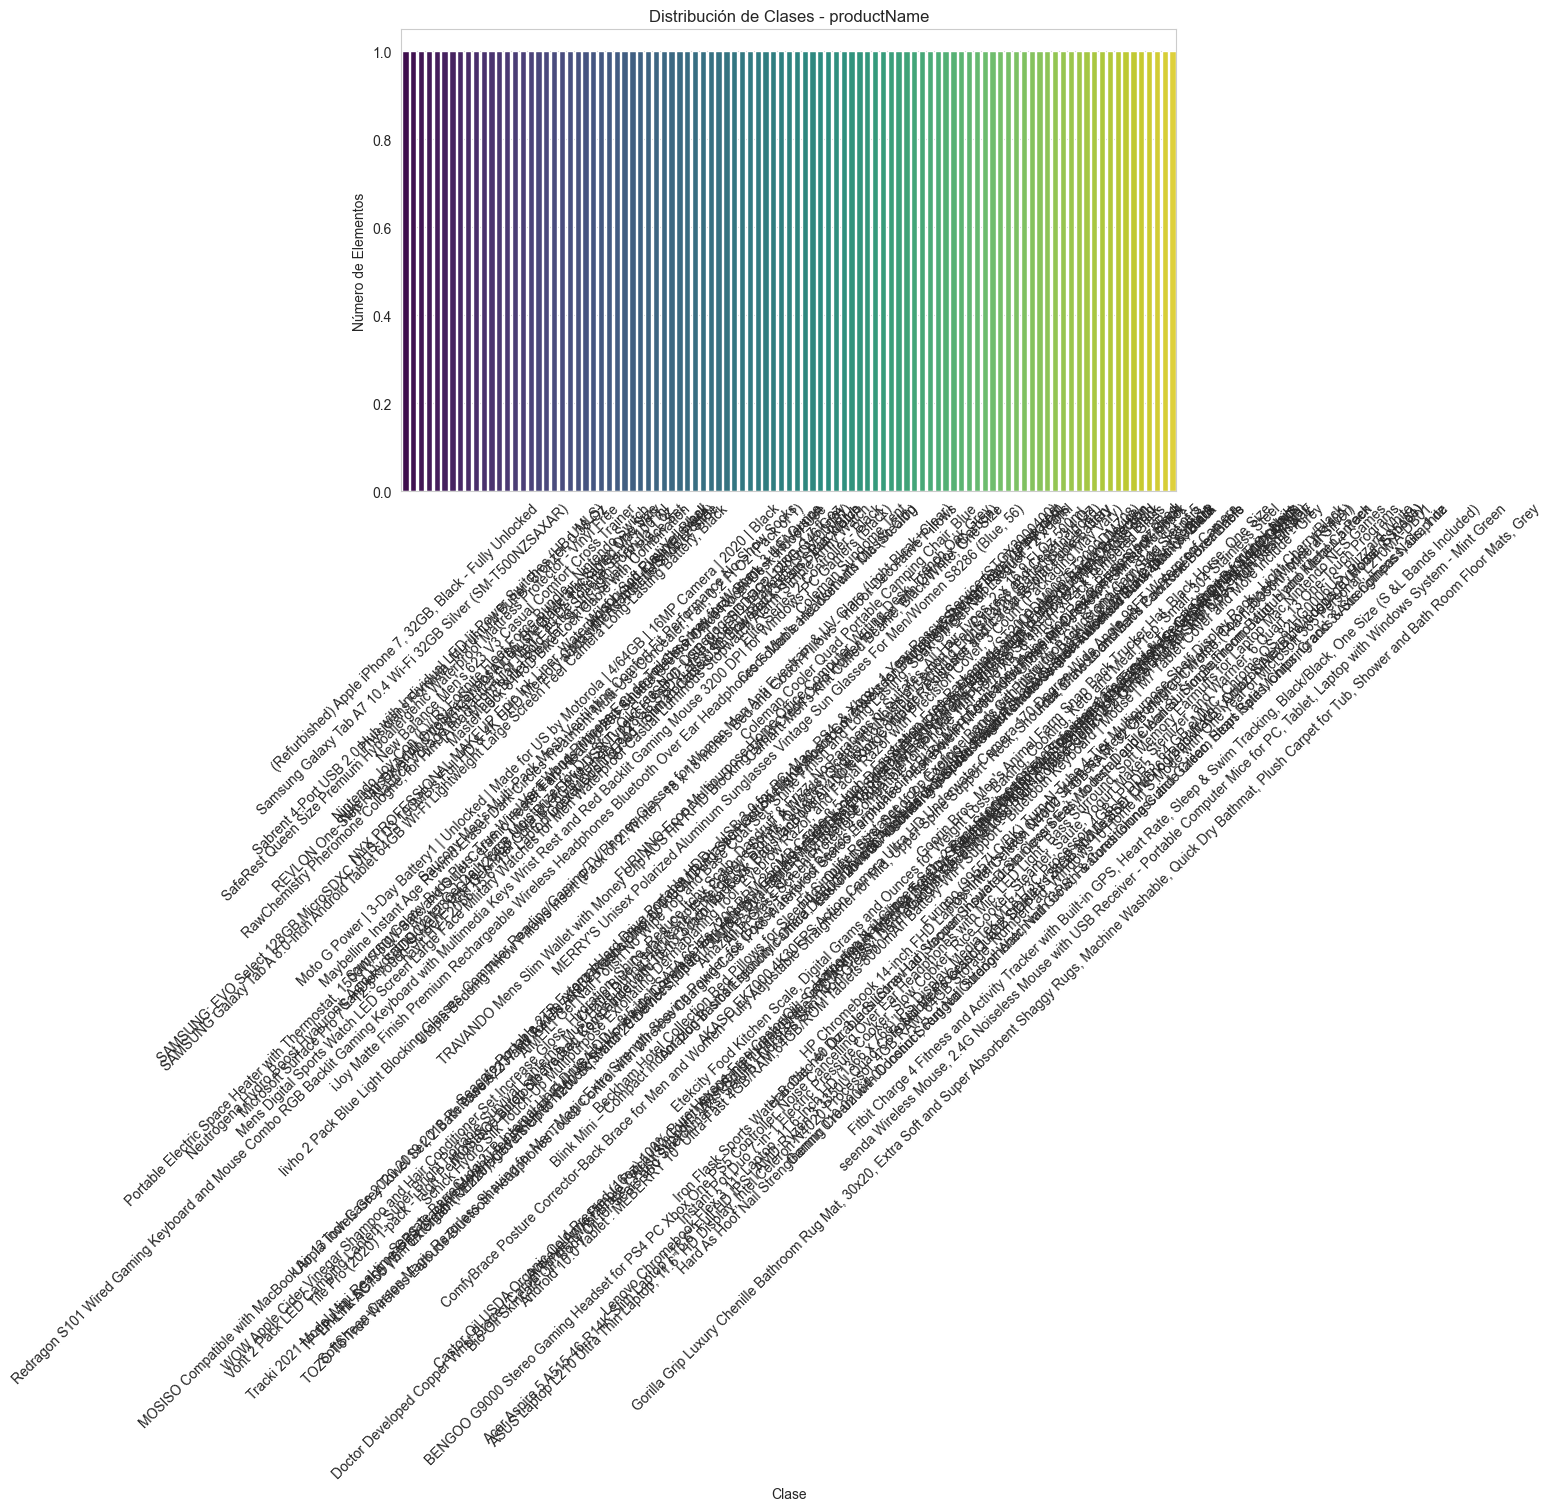

In [221]:
exp_nlp.explorar_datos()

In [222]:
exp_nlp.limpiar_textos("texto_limpio")

Limpiando el texto...
Texto limpiado y listo.


In [223]:
df = exp_nlp.obtener_dataframe_limpio()
df.sample(5)

,productName,mainDepartment,subDepartment,reviewText,texto_limpio
67,"RawChemistry Pheromone Cologne, for Him [Attra...",Beauty and Personal Care,Fragrance,"Worst product i ever bought on amazon, i norma...",bad product ever buy amazon normally write rev...
68,Redragon S101 Wired Gaming Keyboard and Mouse ...,Computers,Computer Accessories & Peripherals,Price point was perfect and works great! Use ...,price point perfect work great use primarily g...
46,Lasko 2511 36” Oscillating 3-Speed Tower Remot...,Home and Kitchen,"Heating, Cooling & Air Quality",An Irritatingly loud whining fan. Irritating b...,irritatingly loud whine fan irritate regular p...
64,"Physicians Formula, Murumuru Butter, Bronzer, ...",Beauty and Personal Care,Makeup,I already love physician's formula to begin wi...,already love physician formula begin butter br...
24,FURINNO Econ Multipurpose Home Office Computer...,Home and Kitchen,Furniture,It's an okay desk for the price.I opened the p...,okay desk pricei open packaging remove inspect...


## Consulta de similares

In [224]:
lista_productos = df['productName'].tolist()

Mostrando productos similares a SanDisk - SDDDC2-128G-G46 128GB Ultra Dual Drive USB Type-C - USB-C, USB 3.1 - SDDDC2-128G-G46 Gray


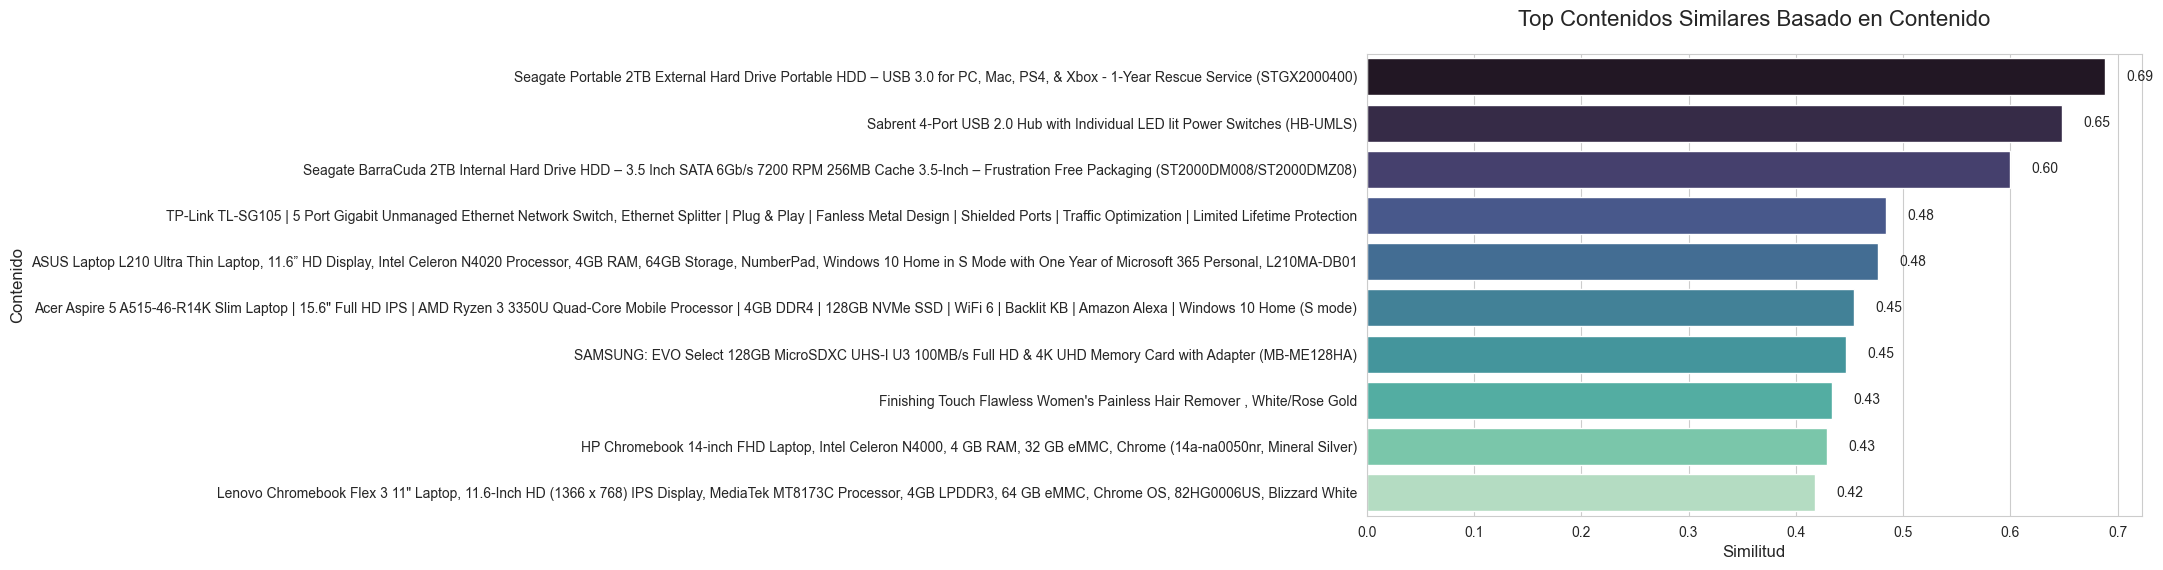

In [235]:
producto = random.choice(lista_productos)
snlp.buscar_similares(df, producto, snlp.vectorizar(df, 'texto_limpio', 1000), 'productName')